In [1]:
from haplogone import read_and_segment, filter_segments_by_size, plot_chromosome, read_bed

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
female = read_and_segment(
    "../../bioinf_semester_project/data/sample_1.vcf", chrom_subset='chrX')
male = read_and_segment(
    "../../bioinf_semester_project/data/sample_2.vcf", chrom_subset="chrX"
)

female_gatk = read_and_segment(
    "../../bioinf_semester_project/data/sample_1/gatk_called.vcf", chrom_subset='chrX'
)
male_gatk = read_and_segment(
    "../../bioinf_semester_project/data/sample_2/gatk_called.vcf", chrom_subset='chrX'
)

In [3]:
ber_chr20 = read_and_segment("../../bioinf_semester_project/vcf_dels/ber_chr20.vcf")
el_chr2 = read_and_segment("../../bioinf_semester_project/vcf_dels/el_chr2.vcf")
em_chr15 = read_and_segment("../../bioinf_semester_project/vcf_dels/em_chr15.vcf")
er_chr1 = read_and_segment("../../bioinf_semester_project/vcf_dels/er_chr1.vcf")
ok_chr1 = read_and_segment("../../bioinf_semester_project/vcf_dels/ok_chr1.vcf")

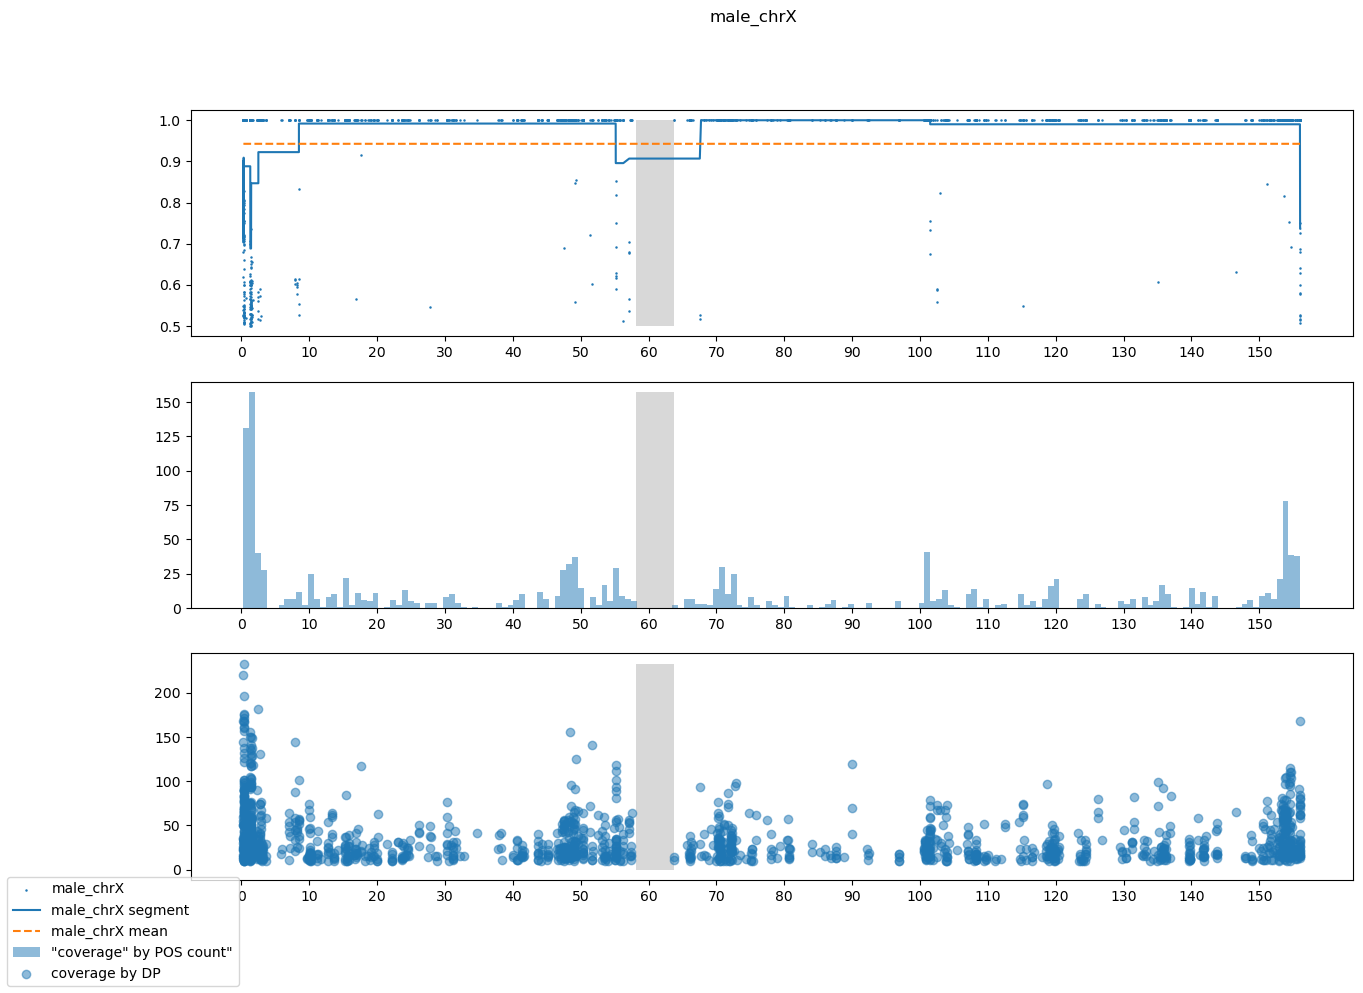

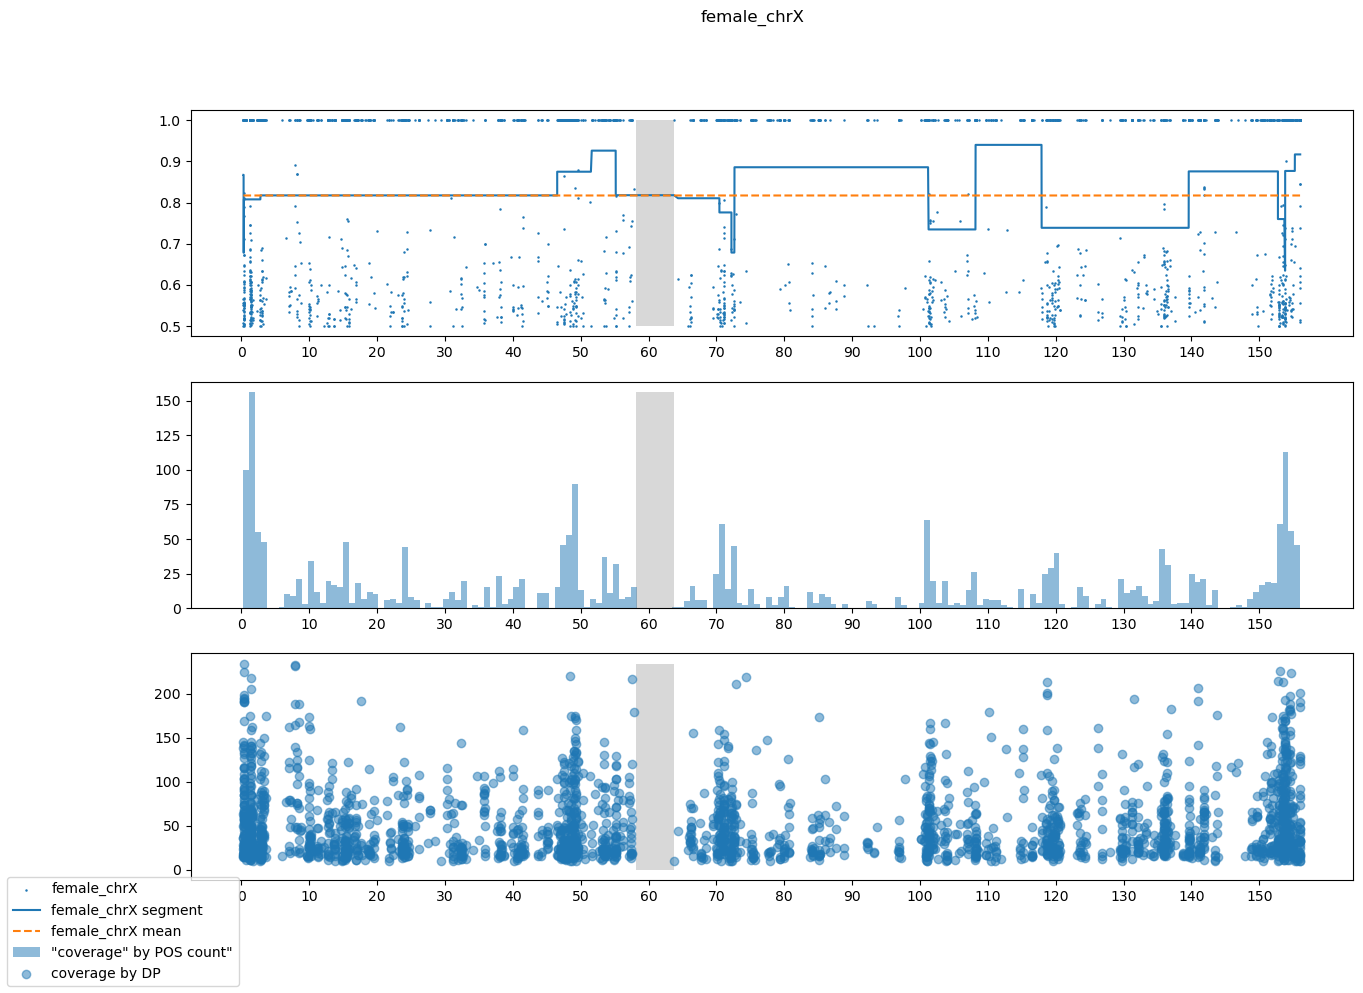

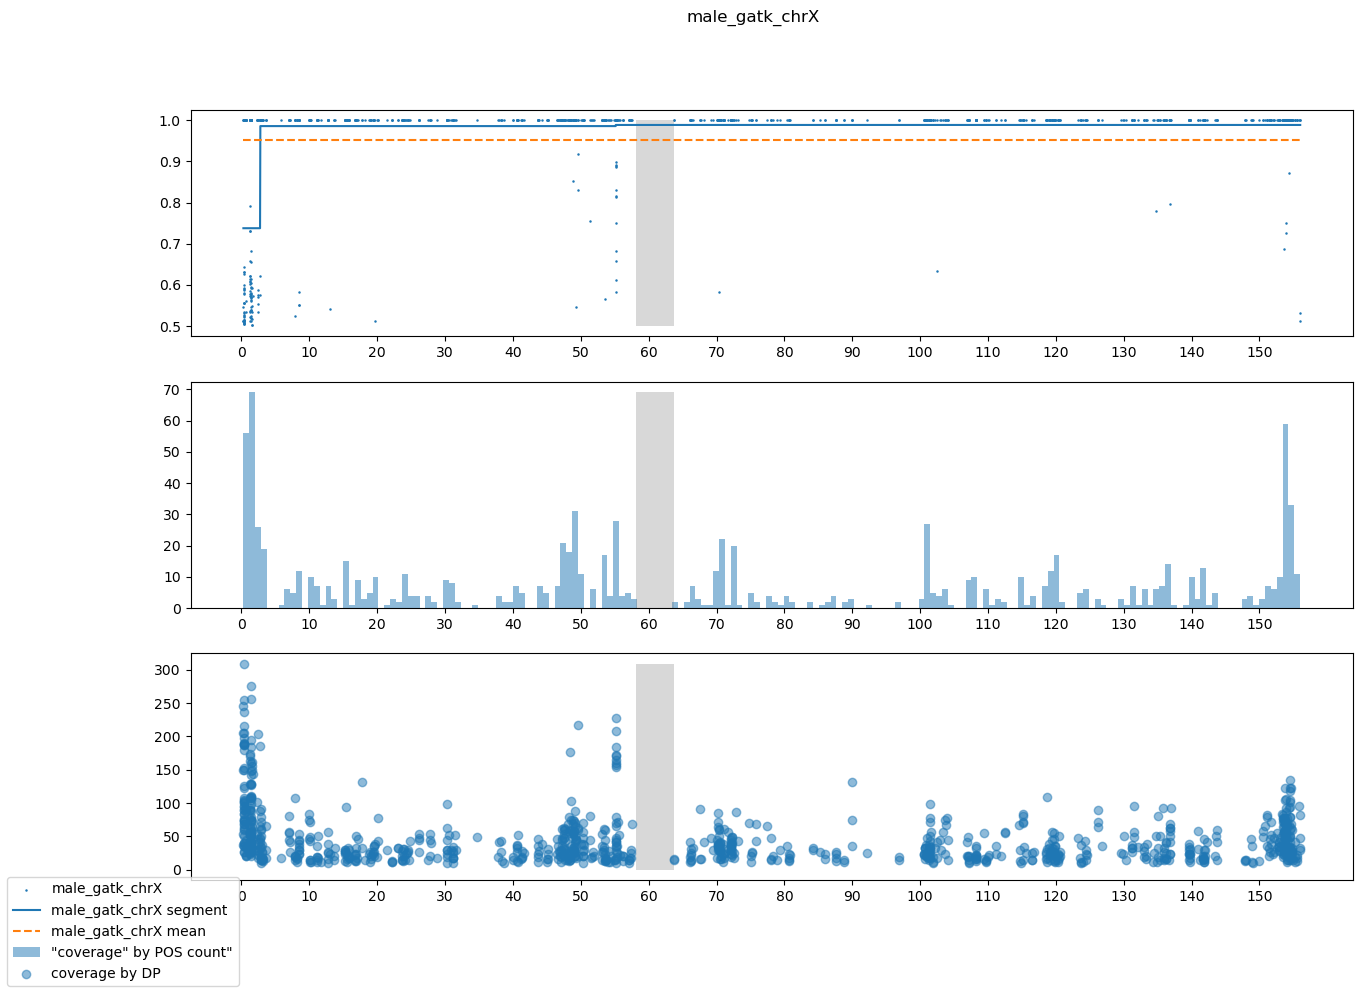

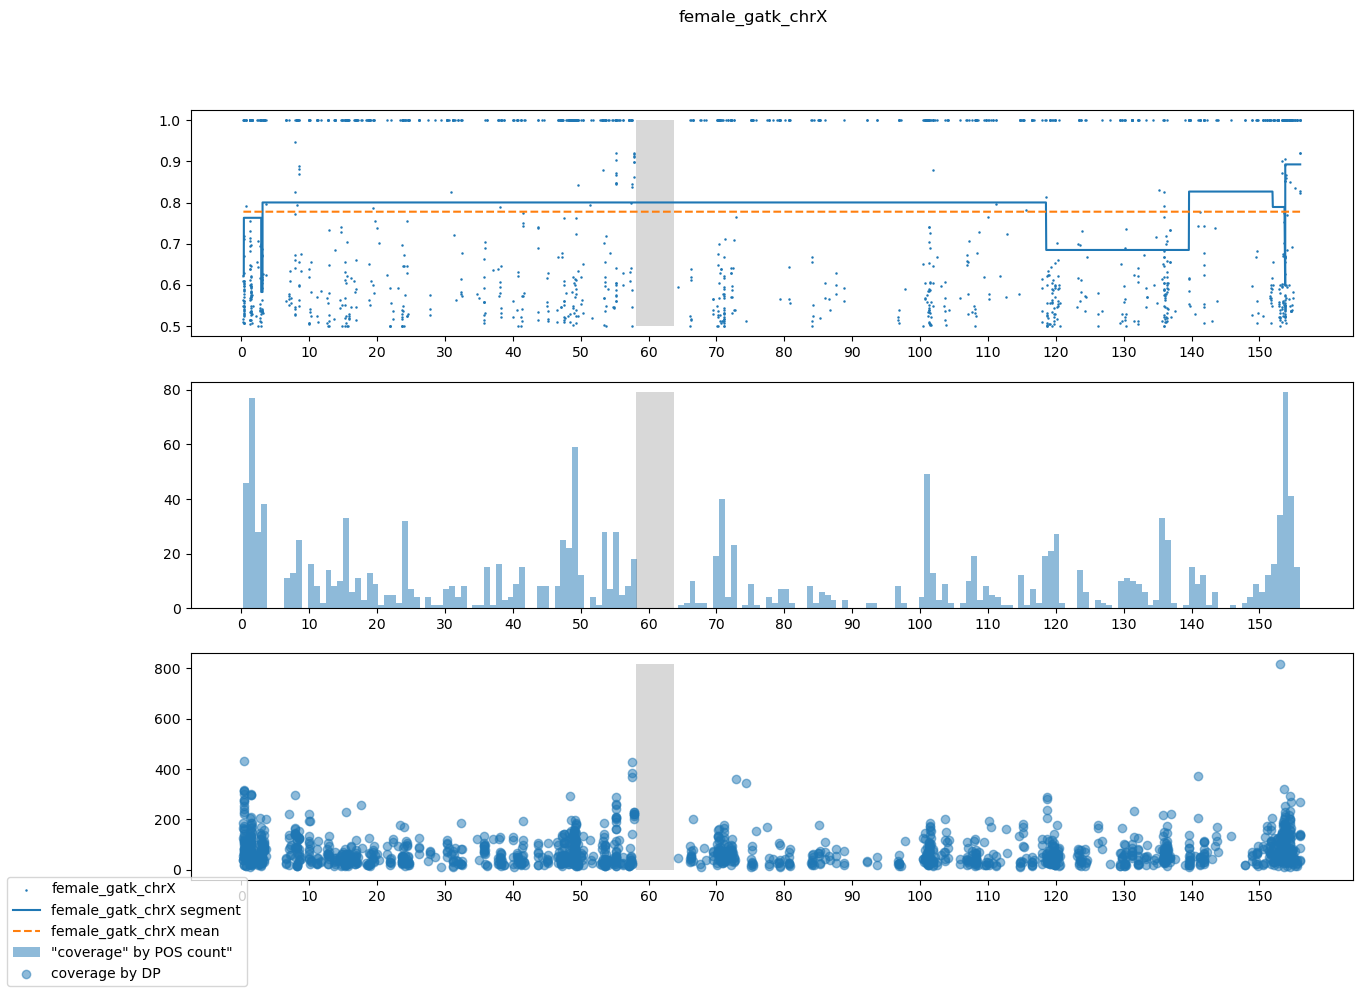

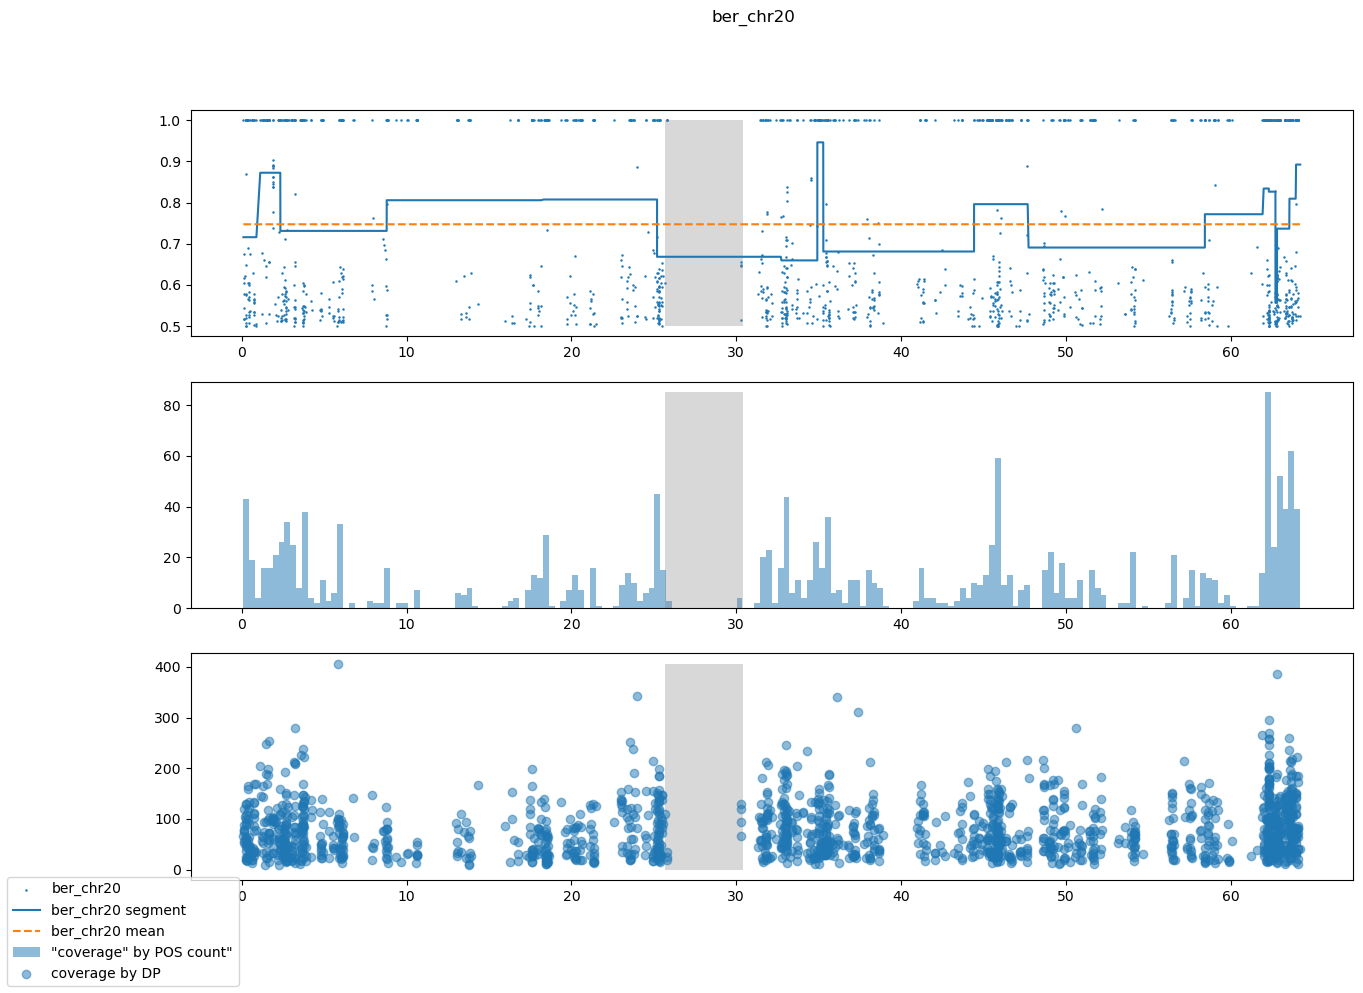

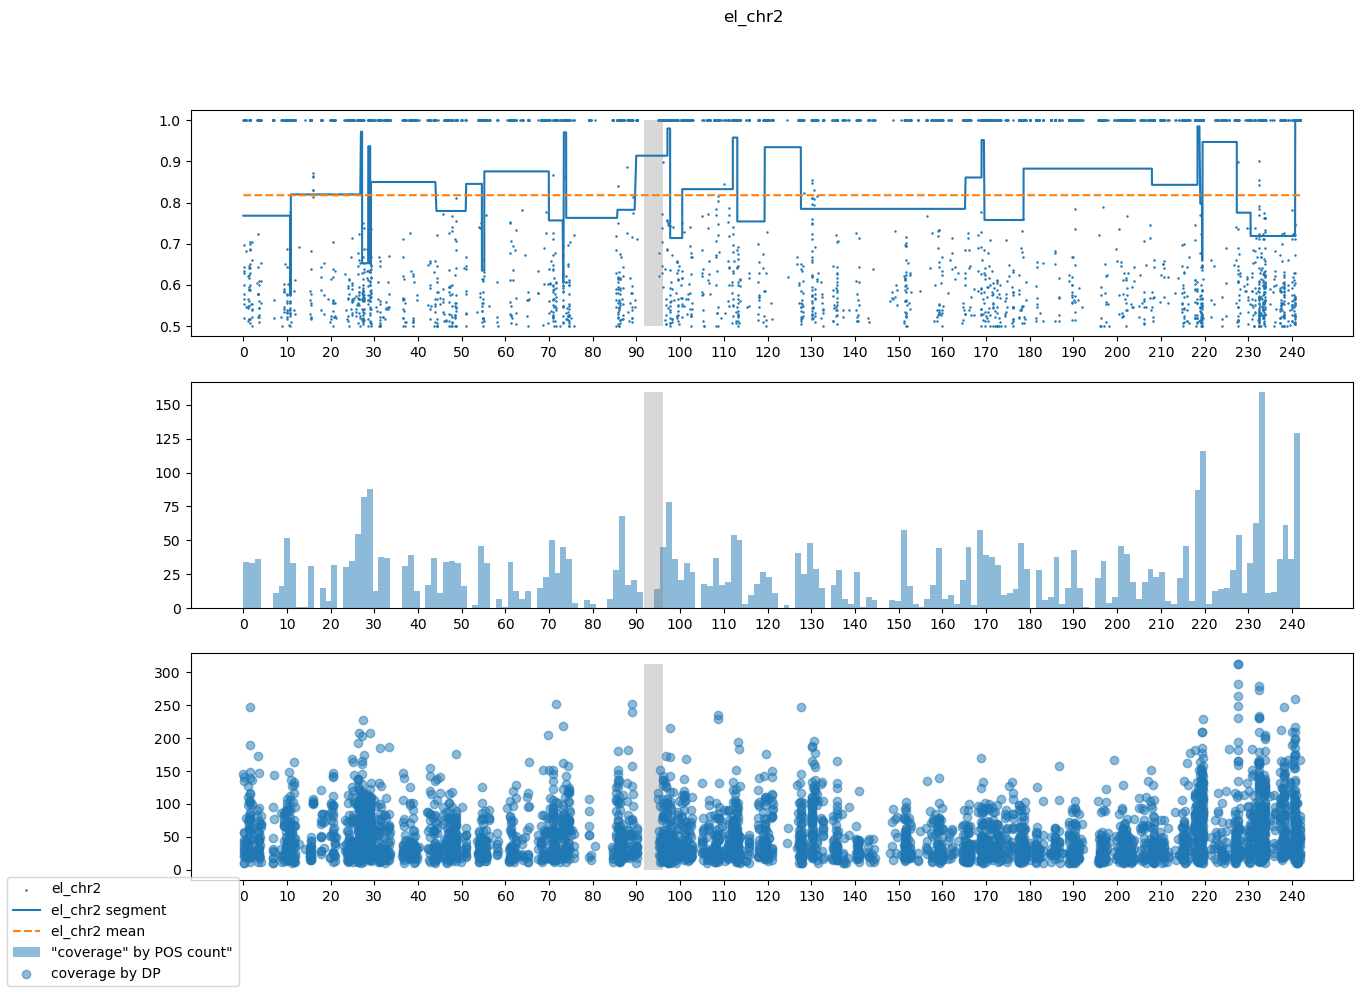

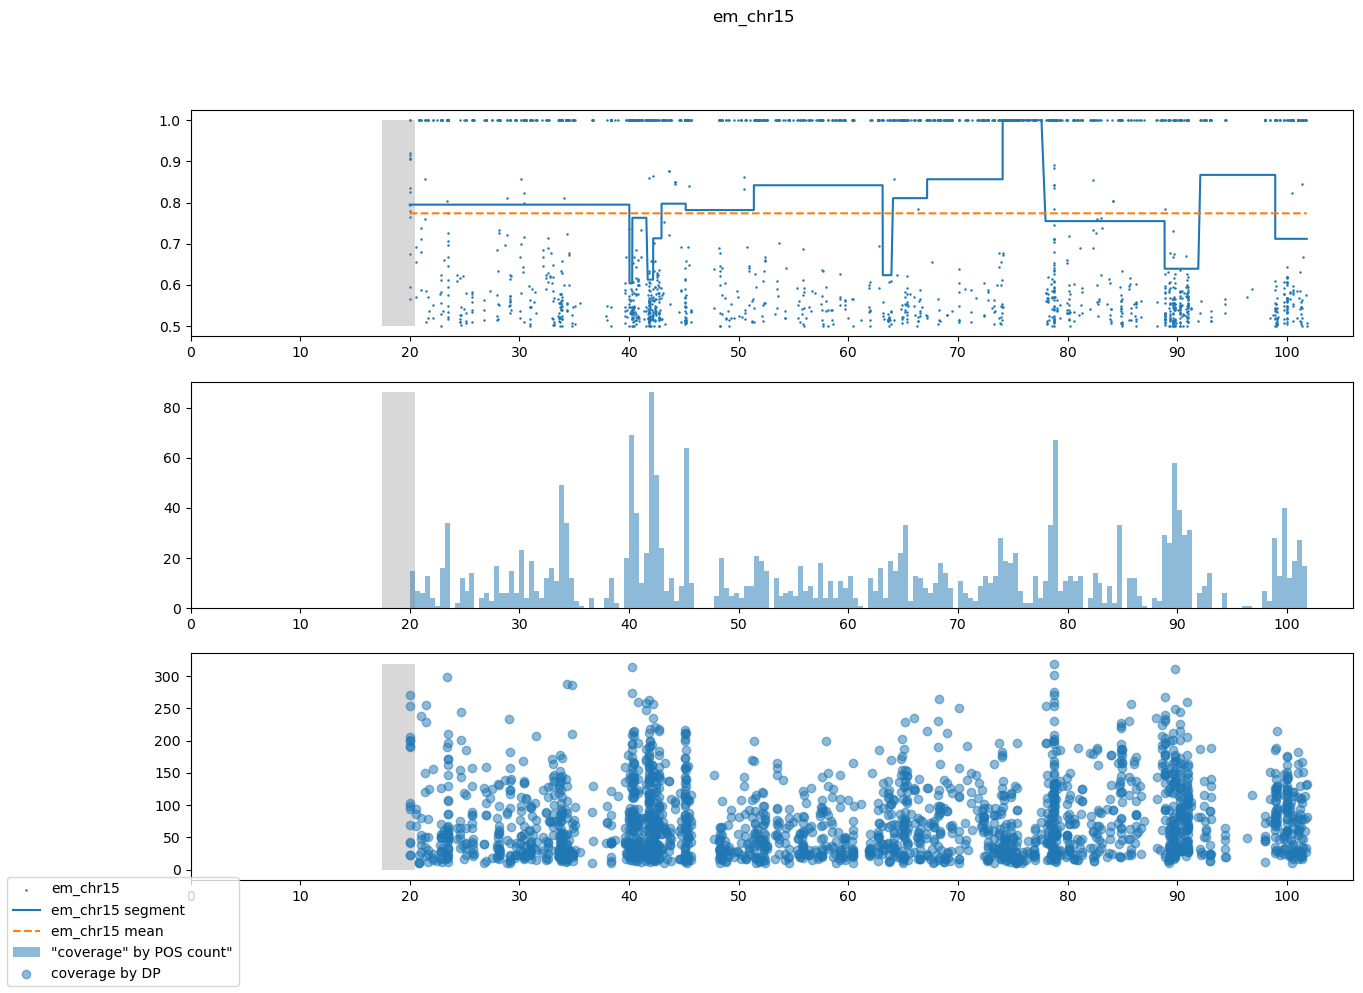

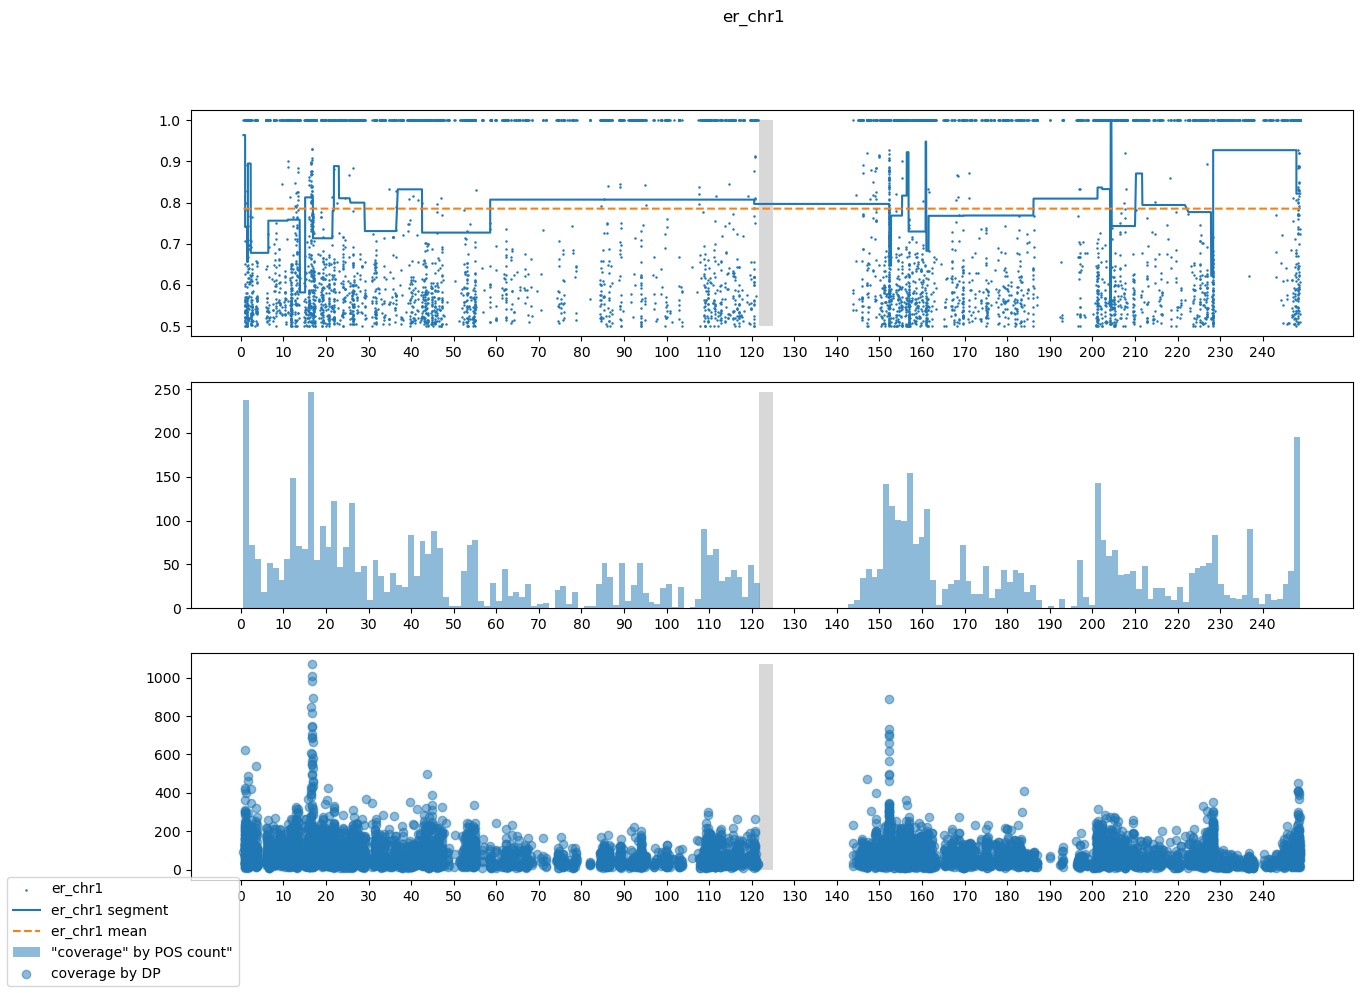

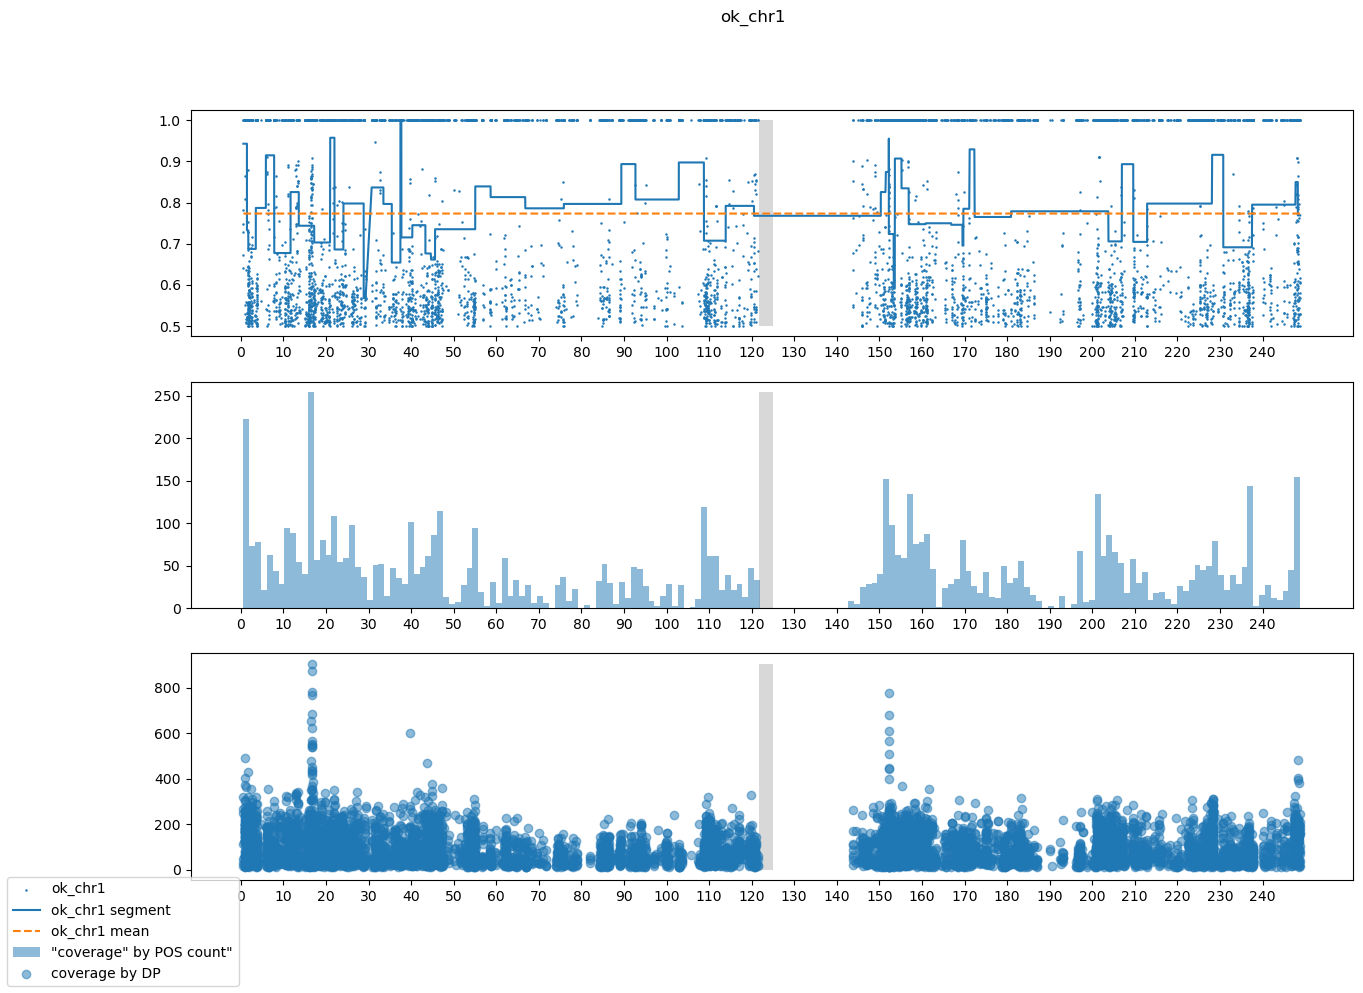

In [4]:
plot_chromosome(male, "male_chrX", "chrX")
plot_chromosome(female, "female_chrX", "chrX")
plot_chromosome(male_gatk, "male_gatk_chrX", "chrX")
plot_chromosome(female_gatk, "female_gatk_chrX", "chrX")
plot_chromosome(ber_chr20, "ber_chr20", "chr20")
plot_chromosome(el_chr2, "el_chr2", "chr2")
plot_chromosome(em_chr15, "em_chr15", "chr15")
plot_chromosome(er_chr1, "er_chr1", "chr1")
plot_chromosome(ok_chr1, "ok_chr1", "chr1")